In [31]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

In [32]:
# Constants
out_classes = 10
epochs = 40
train_split_limit = 0.8
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
# Defining the transform pipeline
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Loading dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Train/Test Split
train_size = int(train_split_limit * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Defining data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_size, shuffle=False)

In [34]:
# Defining the model
class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=1)
        self.pool1 = nn.AvgPool2d(kernel_size=3, padding=1, stride=1)

        self.conv2 = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2352, 64)
        self.fc2 = nn.Linear(64, out_classes)
        self.softmax = nn.Softmax(1)

    def forward(self, data: torch.Tensor):
        # First convolution layer
        data = self.conv1(data)
        data = self.pool1(data)

        # Second convolution layer
        data = self.conv2(data)
        data = self.pool2(data)

        # Flattening and feed forward
        data = self.flatten(data)
        data = self.fc1(data)
        data = self.fc2(data)
        
        # Normalization
        data = self.softmax(data)
        return data

In [35]:
model = Model().to(device=device)
criterion = nn.CrossEntropyLoss().to(device=device)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_data = []
accuracy_data = []

In [36]:
for epoch in range(1, epochs + 1):
    total_loss = 0
    loss_count = 0

    # Training phase
    model.train()
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        labels = torch.zeros((len(Y), 10), device=device)
        for i in range(len(Y)):
            # Turning numerical class to a one-hot encoded tensor 
            labels[i] = nn.functional.one_hot(Y[i], 10).to(device)
        
        opt.zero_grad()
        y_pred: torch.Tensor = model(X)
        loss = criterion(y_pred, labels)
        loss.backward()
        opt.step()
        total_loss += float(loss)
        loss_count += 1

    # Evaluation phase
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for X, Y in val_loader:
            X, Y = X.to(device), Y.to(device)
            y_pred = model(X)
            total_correct += (y_pred.argmax(dim=1) == Y).sum().item()
    
    # Calculating performance
    accuracy = round((total_correct / val_size) * 100, 2)
    accuracy_data.append(accuracy)

    avg_loss = round((total_loss / loss_count) * 100, 2)
    loss_data.append(avg_loss)
    print(f"Epoch #{epoch} | Accuracy : {accuracy}% | Loss : {avg_loss}")

Epoch #1 | Accuracy : 90.08% | Loss : 166.08
Epoch #2 | Accuracy : 91.39% | Loss : 154.89
Epoch #3 | Accuracy : 92.58% | Loss : 153.68
Epoch #4 | Accuracy : 93.08% | Loss : 152.81
Epoch #5 | Accuracy : 93.67% | Loss : 152.15
Epoch #6 | Accuracy : 93.23% | Loss : 151.71
Epoch #7 | Accuracy : 93.8% | Loss : 151.18
Epoch #8 | Accuracy : 94.47% | Loss : 150.86
Epoch #9 | Accuracy : 95.22% | Loss : 150.46
Epoch #10 | Accuracy : 94.92% | Loss : 150.21
Epoch #11 | Accuracy : 95.83% | Loss : 149.92
Epoch #12 | Accuracy : 95.38% | Loss : 149.75
Epoch #13 | Accuracy : 95.72% | Loss : 149.59
Epoch #14 | Accuracy : 96.34% | Loss : 149.36
Epoch #15 | Accuracy : 95.78% | Loss : 149.31
Epoch #16 | Accuracy : 96.45% | Loss : 149.36
Epoch #17 | Accuracy : 96.45% | Loss : 149.05
Epoch #18 | Accuracy : 96.71% | Loss : 148.99
Epoch #19 | Accuracy : 96.06% | Loss : 148.87
Epoch #20 | Accuracy : 96.82% | Loss : 148.84
Epoch #21 | Accuracy : 96.85% | Loss : 148.73
Epoch #22 | Accuracy : 97.05% | Loss : 148.7

Maximum accuracy : 97.24%


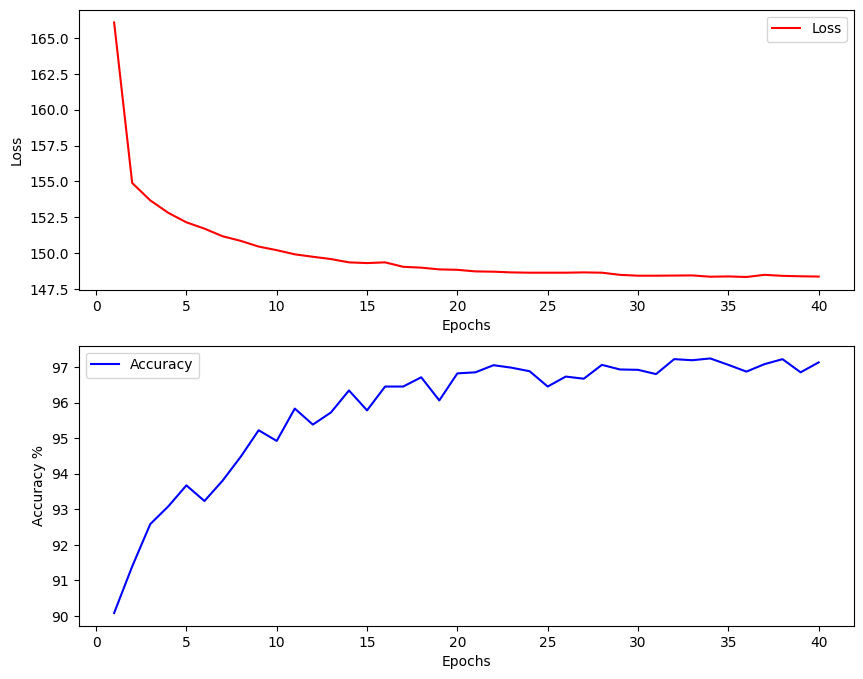

In [39]:
# Plotting performance
import matplotlib.pyplot as plt

print(f"Maximum accuracy : {max(accuracy_data)}%")

x_epoch = range(1, epochs + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.plot(x_epoch, loss_data, 'r', label="Loss")
ax1.legend()

ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy %")
ax2.plot(x_epoch, accuracy_data, 'b', label="Accuracy")
ax2.legend()

plt.show()